In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# To Define Your CNN Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# For the confusion martix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Reading the files
images = images = np.load("images.npy")
labels = pd.read_csv("labels.csv")

In [3]:
# Checking shape of data, making sure it is correct
print(labels.shape)

(4750, 1)


In [4]:
# Checking shape of data, making sure it is correct
print(images.shape)

(4750, 128, 128, 3)


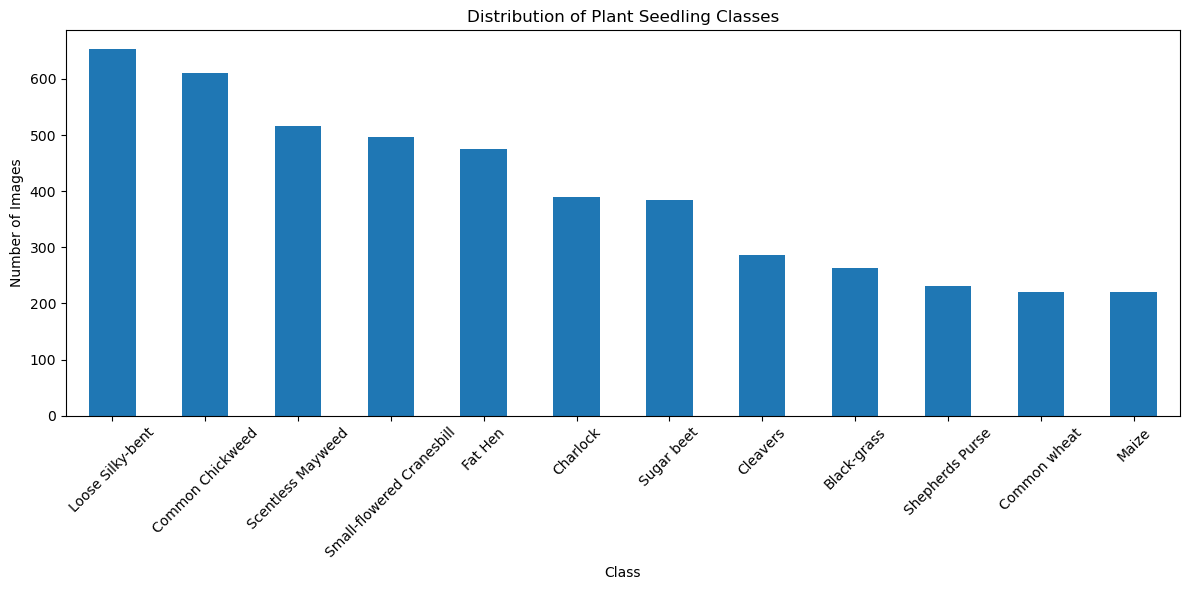

In [5]:
# Exploritory data, the distribution of different classses
plt.figure(figsize=(12,6))
labels['Label'].value_counts().plot(kind='bar')
plt.title("Distribution of Plant Seedling Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

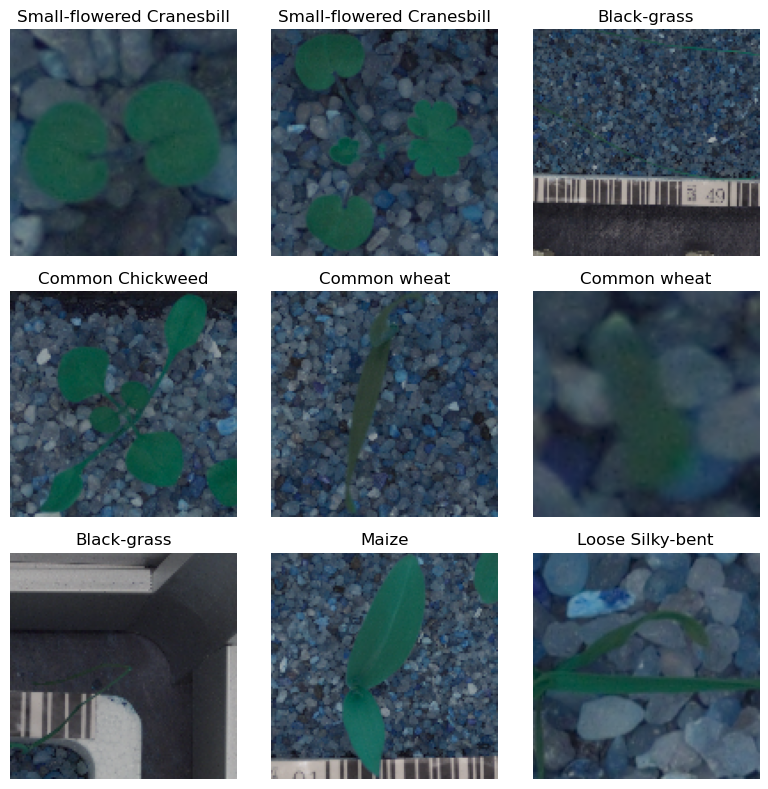

In [6]:
# Exploriring data, sample images associated with the labels 
sample_labels = labels['Label'].values

# Show 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(0, len(images))
    ax.imshow(images[index])
    ax.set_title(sample_labels[index])
    ax.axis('off')
plt.tight_layout()
plt.show()

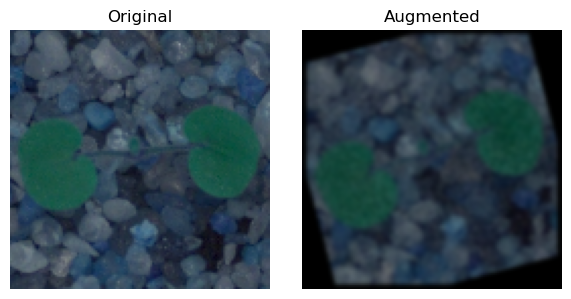

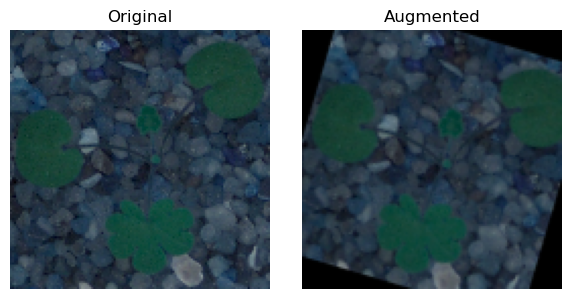

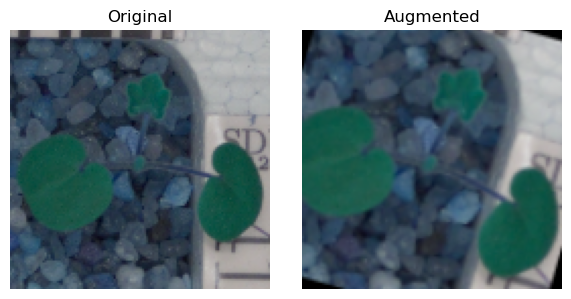

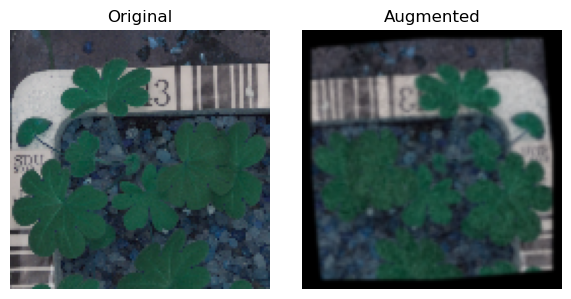

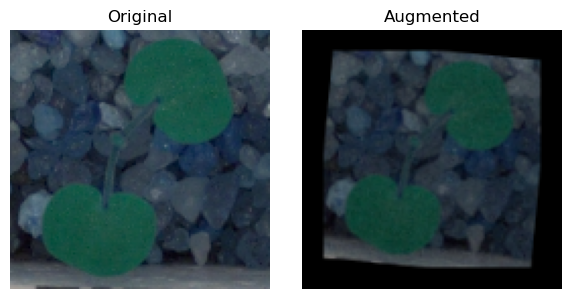

In [7]:
# Data augmentation
# Sample a few images from your dataset
sample_images = images[:5]  # shape: (128, 128, 3)

# Define the augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),                             # Flip 50% of images horizontally
    iaa.Affine(scale=(0.8, 1.2)),                # Zoom in/out 80% to 120%
    iaa.Affine(rotate=(-25, 25)),                # Rotate between -25 and 25 degrees
    iaa.GaussianBlur(sigma=(0.0, 1.0)),          # Apply Gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    iaa.Multiply((0.8, 1.2)),                    # Adjust brightness
], random_order=True)  # Randomize the order of the augmentations

# Apply the augmentation
augmented_images = seq(images=sample_images)

# Display original and augmented side-by-side
for i in range(len(sample_images)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(sample_images[i])
    ax1.set_title("Original")
    ax1.axis('off')

    ax2.imshow(augmented_images[i])
    ax2.set_title("Augmented")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# Normalize pixel values to range [0, 1]
images_normalized = images.astype("float32") / 255.0

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels['Label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp['Label'], random_state=42)

In [10]:
# Initialize encoder
le = LabelEncoder()

# Fit and transform labels
labels_encoded = le.fit_transform(labels.values.ravel())

# Check sample
print(labels_encoded[:5])
print(le.classes_)

[10 10 10 10 10]
['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [11]:
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("X_val.npy", X_val)

y_train.to_csv("Ytrain_df.csv", index=False)
y_test.to_csv("Ytest_df.csv", index=False)
y_val.to_csv("Yval_df.csv", index=False)

print("Train and test datasets saved successfully.")

Train and test datasets saved successfully.


In [12]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # converts from HWC [0-255] to CHW [0-1]
])

In [13]:
# Create a Custom Dataset Class
class PlantDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [14]:
# Convert and Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train["Label"])
y_val_encoded = label_encoder.transform(y_val["Label"])
y_test_encoded = label_encoder.transform(y_test["Label"])

In [15]:
# Create PyTorch Datasets
train_dataset = PlantDataset(X_train, y_train_encoded, transform=transform)
val_dataset = PlantDataset(X_val, y_val_encoded, transform=transform)
test_dataset = PlantDataset(X_test, y_test_encoded, transform=transform)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
class PlantCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(PlantCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Because input is 128x128 and we pool down by 2 three times: 128 -> 64 -> 32 -> 16
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
# Set Up Training Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PlantCNN(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_losses = []
val_losses = []

max_batches = 10  # Limit to 10 batches per epoch for quicker runs
epochs = 19 # Limit to 20 Epochs

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training loop
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if batch_idx >= max_batches:
            break  # Exit early after `max_batches`

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Batch {batch_idx}/{max_batches}, Loss: {loss.item():.4f}")
    
    avg_train_loss = running_loss / max_batches
    train_losses.append(avg_train_loss)
    print(f"Average Training Loss (epoch {epoch+1}): {avg_train_loss:.4f}")

    # Validation loop (after each epoch)
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Average Validation Loss (epoch {epoch+1}): {avg_val_loss:.4f}")


Epoch 1/20
Batch 0/10, Loss: 2.4857
Batch 1/10, Loss: 2.4820
Batch 2/10, Loss: 2.4119
Batch 3/10, Loss: 2.4361
Batch 4/10, Loss: 2.3512
Batch 5/10, Loss: 2.2922
Batch 6/10, Loss: 2.4030
Batch 7/10, Loss: 2.3967
Batch 8/10, Loss: 2.4379
Batch 9/10, Loss: 2.4249
Average Training Loss (epoch 1): 2.4121
Average Validation Loss (epoch 1): 2.4151
Epoch 2/20
Batch 0/10, Loss: 2.3568
Batch 1/10, Loss: 2.4297
Batch 2/10, Loss: 2.4197
Batch 3/10, Loss: 2.4133
Batch 4/10, Loss: 2.3914
Batch 5/10, Loss: 2.4337
Batch 6/10, Loss: 2.5289
Batch 7/10, Loss: 2.4245
Batch 8/10, Loss: 2.4469
Batch 9/10, Loss: 2.4379
Average Training Loss (epoch 2): 2.4283
Average Validation Loss (epoch 2): 2.4044
Epoch 3/20
Batch 0/10, Loss: 2.3469
Batch 1/10, Loss: 2.3501
Batch 2/10, Loss: 2.3102
Batch 3/10, Loss: 2.4584
Batch 4/10, Loss: 2.1751
Batch 5/10, Loss: 2.3431
Batch 6/10, Loss: 2.3176
Batch 7/10, Loss: 2.6631
Batch 8/10, Loss: 2.3913
Batch 9/10, Loss: 2.5088
Average Training Loss (epoch 3): 2.3865
Average Valid

Epoch means that one complete pass through the entire training dataset by the model has happened
The lower the loss means the better the model is doing

In [19]:
# Validation Accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 63.34%


In [20]:
# print model
print(model)

PlantCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=12, bias=True)
)


Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])
Before permute: torch.Size([32, 3, 128, 128])
After permute: torch.Size([32, 3, 128, 128])

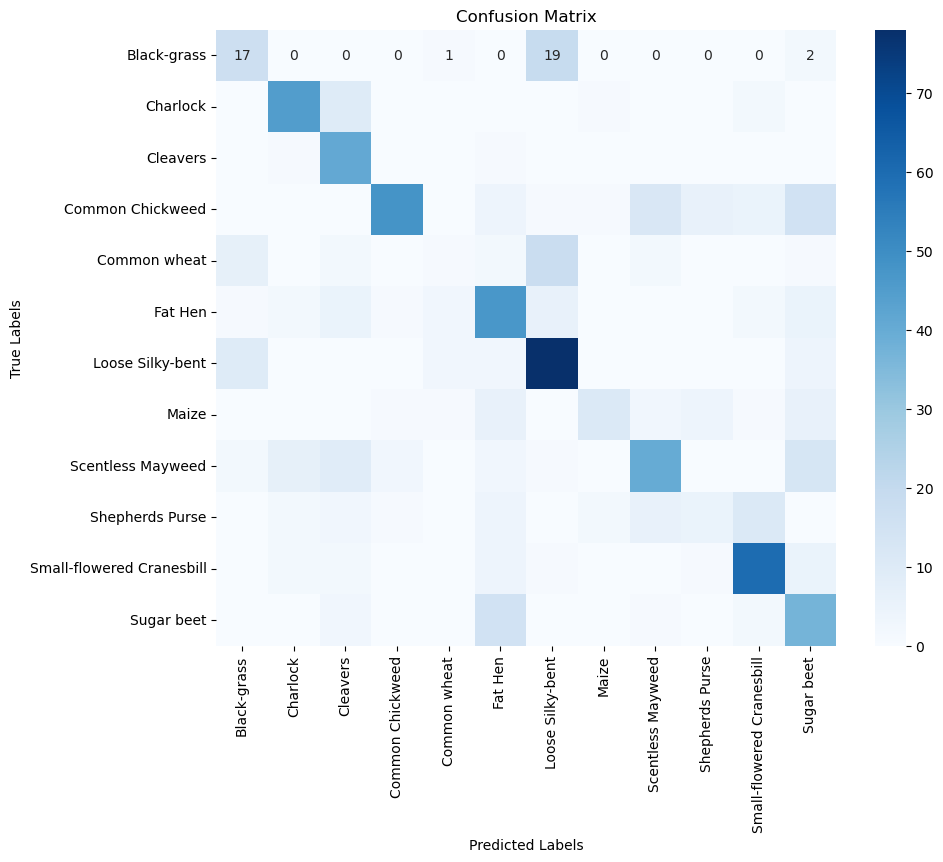

In [21]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
all_preds = []
all_labels = []

# Loop through the test data (assuming you're using a DataLoader for batch processing)
with torch.no_grad():  # No need to track gradients for inference
    for images, labels in test_loader:
        # Ensure data is on the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        # Debugging: Print the shape before permuting
        print("Before permute:", images.shape)
        
        # Debugging: Print the shape after permuting
        print("After permute:", images.shape)

        # Get the model’s predictions
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels
        
        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


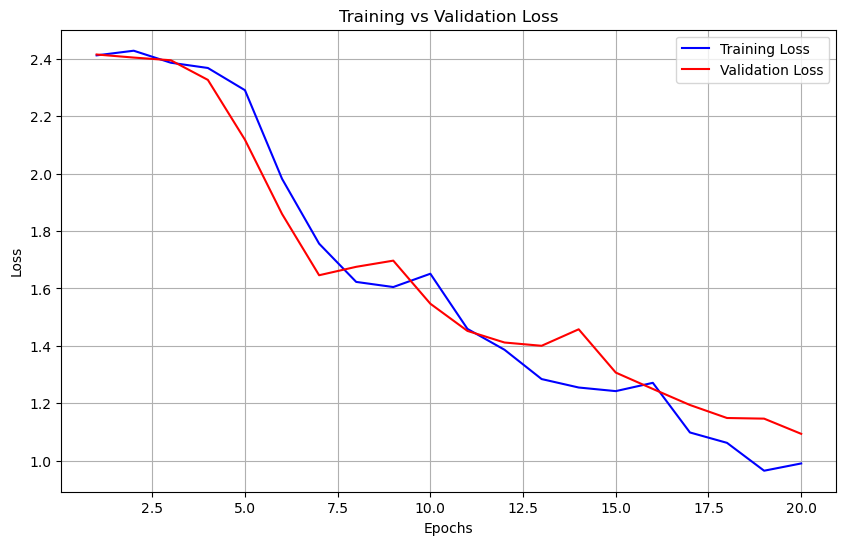

In [22]:
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Save the model
torch.save(model.state_dict(), 'plant_seedling_model.pth')

In [24]:
# To load the model later
model.load_state_dict(torch.load('plant_seedling_model.pth'))
model.eval()  # Set the model to evaluation mode

PlantCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=12, bias=True)
)